In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from network import PointVAE
import MC_data_generator

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
NUM_USERS=100
POINTS_PER_USER=4096

vae_dataset_numpy = create_dataset(NUM_USERS, POINTS_PER_USER)

Generating dataset for 100 users with 4096 points each...
Dataset generation complete.


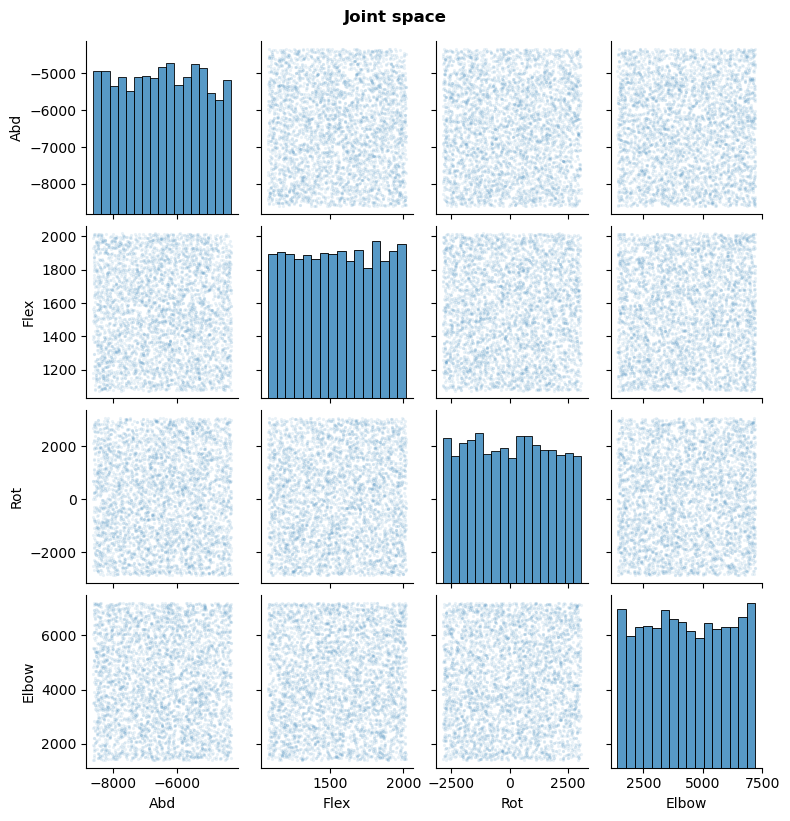

In [15]:
# Convert to degrees for easier interpretation in plots
cloud_tensor = torch.tensor(vae_dataset_numpy, dtype=torch.float32).to(device)
cloud_deg = torch.rad2deg(cloud_tensor.cpu()).numpy()

df = pd.DataFrame(cloud_deg[1], columns=['Abd', 'Flex', 'Rot', 'Elbow'])

# Create the pairplot
g = sns.pairplot(df, 
                    kind='scatter', 
                    diag_kind='hist',
                    plot_kws={'alpha': 0.1, 's': 5}, # Small, transparent points
                    height=2) # Size of each plot

g.fig.suptitle("Joint space", y=1.02, fontweight='bold')
plt.show()

In [ ]:

# --- 2. Load Your Trained Model ---
# (Make sure to instantiate with the same params as training)
LATENT_DIM = 128
POINTS_PER_USER = 4096

model = PointVAE(latent_dim=LATENT_DIM, num_points_k=POINTS_PER_USER)
model.load_state_dict(torch.load("point_vae_model.pth"))
model.to(device)
model.eval() # Set model to evaluation mode (disables dropout, etc.)

print("Model loaded.")

# --- 3. Create a Validation DataLoader ---
# We'll generate a small, new set of 10 users for validation
print("Generating validation data...")
validation_dataset_numpy = create_dataset(num_users=10, num_points_per_user=POINTS_PER_USER)
validation_loader = get_dataloader(validation_dataset_numpy, batch_size=2)

# --- 4. Plotting Helper Function ---
def plot_joint_cloud(cloud_tensor, title="Joint Space Point Cloud"):
    """
    Plots a 4D joint-space point cloud using a Seaborn PairPlot.
    Assumes input is a [K, 4] tensor in RADIANS.
    """
    # Convert to degrees for easier interpretation in plots
    cloud_deg = torch.rad2deg(cloud_tensor.cpu()).numpy()
    
    df = pd.DataFrame(cloud_deg, columns=['Abd', 'Flex', 'Rot', 'Elbow'])
    
    # Create the pairplot
    g = sns.pairplot(df, 
                     kind='scatter', 
                     diag_kind='hist',
                     plot_kws={'alpha': 0.1, 's': 5}, # Small, transparent points
                     height=2) # Size of each plot
    
    g.fig.suptitle(title, y=1.02, fontweight='bold')
    plt.show()

In [ ]:
# --- Get one batch of validation data ---
input_cloud_batch = next(iter(validation_loader))[0].to(device)

# --- Run the model ---
with torch.no_grad(): # We don't need to track gradients
    recon_cloud_batch, _, _ = model(input_cloud_batch)

# --- Select the first user from the batch for plotting ---
input_cloud = input_cloud_batch[0]
recon_cloud = recon_cloud_batch[0]

print(f"Plotting Input vs. Reconstruction for Validation User 0")

# --- Plot the original ---
plot_joint_cloud(input_cloud, title="Original Input Cloud")

# --- Plot the reconstruction ---
plot_joint_cloud(recon_cloud, title="VAE Reconstructed Cloud")

In [2]:
BASE_LIMITS_DEG = np.array([
    [-180.0, 20.0],  # Abd (Ry)
    [-60.0, 180.0],  # Flex (Rx)
    [-60.0, 90.0],   # Rot (Rz)
    [0.0, 150.0]     # Elbow (Rx)
])

from data_generator import sample_joint_space_randomly

In [ ]:
print("\n--- Starting Latent Space Interpolation Test ---")

# --- 1. Manually create our two "extreme" users ---
# Impaired user: very limited range
impaired_limits = np.array([
    [-40.0, 0.0],    # Abd
    [-30.0, 30.0],   # Flex
    [-20.0, 20.0],   # Rot
    [0.0, 20.0]      # Elbow
])

# Healthy user: full range
healthy_limits = BASE_LIMITS_DEG 

# --- 2. Generate their point clouds ---
impaired_cloud_deg = sample_joint_space_randomly(impaired_limits, POINTS_PER_USER)
healthy_cloud_deg = sample_joint_space_randomly(healthy_limits, POINTS_PER_USER)

# --- 3. Convert to Tensors (in RADIANS) and add a batch dim ---
impaired_cloud_rad = torch.deg2rad(torch.tensor(impaired_cloud_deg, dtype=torch.float32)).unsqueeze(0).to(device)
healthy_cloud_rad = torch.deg2rad(torch.tensor(healthy_cloud_deg, dtype=torch.float32)).unsqueeze(0).to(device)

# --- 4. Encode them to get their latent vectors ---
with torch.no_grad():
    # We only care about the 'mu' (the mean) as the representative latent vector
    _, z_mu_impaired, _ = model(impaired_cloud_rad)
    _, z_mu_healthy, _ = model(healthy_cloud_rad)

# --- 5. Interpolate in the latent space ---
interpolation_steps = 5
for i, t in enumerate(np.linspace(0, 1, interpolation_steps)):
    
    print(f"\nPlotting interpolated user: {t*100:.0f}% Healthy")
    
    # t=0 -> impaired, t=1 -> healthy
    # This is a Linear Interpolation (LERP)
    z_new = torch.lerp(z_mu_impaired, z_mu_healthy, t)
    
    # --- 6. Decode the new 'z' vector ---
    with torch.no_grad():
        interpolated_cloud = model.decoder(z_new)
    
    # Plot the result (remove batch dim for plotting)
    plot_joint_cloud(interpolated_cloud[0], 
                     title=f"Interpolated Cloud (t={t:.2f})")

In [3]:
import time
from loss_functions import vae_loss_function

In [5]:
# Data params (MUST match your trained model's architecture)
POINTS_PER_USER = 4096
LATENT_DIM = 128

# Validation run params
NUM_VAL_USERS = 200     # How many new, unseen users to test on
VAL_BATCH_SIZE = 64     # Can be larger than training (no backprop)
MODEL_FILE_PATH = "point_vae_model.pth" 
BETA = 1.0              # Must be the same as used in training

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Starting Validation ---")
print(f"Using device: {device}")

# --- 2. Generate a NEW, unseen validation dataset ---
print(f"Generating {NUM_VAL_USERS} new validation users...")
# (Assumes 'create_dataset' and 'get_dataloader' are defined)
val_dataset_numpy = create_dataset(NUM_VAL_USERS, POINTS_PER_USER)

# Note: shuffle=False is standard for validation/testing
val_loader = get_dataloader(val_dataset_numpy, VAL_BATCH_SIZE)
print("Validation data loaded.")

# --- 3. Load the Trained Model ---
# (Assumes 'PointVAE' class is defined)
model = PointVAE(
    latent_dim=LATENT_DIM,
    num_points_k=POINTS_PER_USER
).to(device)

try:
    model.load_state_dict(torch.load(MODEL_FILE_PATH, map_location=device))
    print("Trained model weights loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Stop execution if the model can't be loaded
    raise e

# *** CRITICAL: Set model to evaluation mode ***
# This disables dropout, batch norm updates, etc.
model.eval()

# --- 4. Run the Validation Loop ---
total_val_loss = 0.0
total_recon_loss = 0.0
total_kld_loss = 0.0

# *** CRITICAL: Disable gradient calculations ***
# This saves memory and computation
with torch.no_grad():
    start_time = time.time()
    
    # (Assumes 'val_loader' is defined)
    for (input_cloud,) in val_loader:
        
        input_cloud = input_cloud.to(device)
        
        # 1. Feed into model
        recon_cloud, mu, logvar = model(input_cloud)
        
        # 2. Calculate Chamfer distance and other losses
        # (Assumes 'vae_loss_function' is defined)
        total_loss, recon_loss, kld_loss = vae_loss_function(
            recon_cloud,
            input_cloud,
            mu,
            logvar,
            beta=BETA
        )
        
        # Accumulate the average loss for this batch
        total_val_loss += total_loss.mean().item()
        total_recon_loss += recon_loss.mean().item()
        total_kld_loss += kld_loss.mean().item()
        
end_time = time.time()

# --- 5. Report Final Metrics ---
num_batches = len(val_loader)
avg_val_loss = total_val_loss / num_batches
avg_recon_loss = total_recon_loss / num_batches
avg_kld_loss = total_kld_loss / num_batches

print("\n--- Validation Complete ---")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print(f"Validation batches: {num_batches}")
print("---------------------------------")
print(f"Average Total Validation Loss: {avg_val_loss:.6f}")
print(f"Average Recon (Chamfer) Loss: {avg_recon_loss:.6f}")
print(f"Average KLD Loss: {avg_kld_loss:.6f}")

--- Starting Validation ---
Using device: cuda
Generating 200 new validation users...
Generating dataset for 200 users with 4096 points each...
Dataset generation complete.
Validation data loaded.


C:\Users\Liu Bodong\AppData\Local\Temp\ipykernel_25324\1843298189.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE_PATH, map_

Trained model weights loaded successfully.

--- Validation Complete ---
Time taken: 1.46 seconds
Validation batches: 3
---------------------------------
Average Total Validation Loss: 1.274155
Average Recon (Chamfer) Loss: 1.271059
Average KLD Loss: 0.003097
